In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import cv2
import random
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from IPython.display import display
from keras.utils.vis_utils import plot_model

In [3]:
if not os.path.isfile('processed_dataset.zip'):
  os.system(' '.join(['cp', 'drive/MyDrive/IT416/processed_dataset.zip', 'processed_dataset.zip']))

In [4]:
if not os.path.isdir('processed_dataset'):
  os.system(' '.join(['unzip', 'processed_dataset.zip']))

In [5]:
def get_dataset(num_people, faces, gait_styles):
  x1 = []
  x2 = []
  y  = []
  for i in tqdm(range(num_people)):

      for j in faces:
          path = 'processed_dataset' + '/' + 'person' + str(i+1) + '/' + 'face' + '/' + str(j+1) + '.pgm'
          image = cv2.imread(path, -1)
          image = cv2.resize(image, (12, 12))
          face = image.reshape(12, 12, 1)

          gait_folder = 'processed_dataset' + '/' + 'person' + str(i+1) + '/' + 'gait' + '/'

          for style in gait_styles:
              
              style_folder = gait_folder + style + '/'
              angles = os.listdir(style_folder)
              angles.sort()
              x = []
              for angle in angles:
                  angle_folder = style_folder + angle + '/'
                  images = os.listdir(angle_folder)
                  random.shuffle(images)
                  images = images[: 16]
                  images.sort()
                  xx = []
                  for image in images:
                      path = angle_folder + image
                      img = cv2.imread(path, -1)
                      img = cv2.resize(img, (32, 32))
                      img = np.array(img, dtype=np.float16)
                      xx.append(img)
                  xx = np.array(xx, dtype=np.float16)
                  x.append(xx)
              gait = np.stack(x, axis=3)

              x1.append(face)
              x2.append(gait)
              y.append(i)

  x1 = np.array(x1, dtype = np.float32)
  x2 = np.array(x2, dtype = np.float32)
  y = tf.keras.utils.to_categorical(y)
  x1, x2, y = shuffle(x1, x2, y)
  return x1, x2, y

In [6]:
num_people = 40

faces = [0, 1, 2, 3, 4, 5, 6]
gait_styles = ['bg-01', 'cl-01', 'nm-01', 'nm-02', 'nm-03', 'nm-04', 'nm-05' ]
x_face, x_gait, y = get_dataset(num_people, faces, gait_styles)

print('x_face:', x_face.shape)
print('x_gait:', x_gait.shape)
print('y     :', y.shape)

faces_val = [7, 8, 9]
gait_styles_val = ['bg-02', 'cl-02', 'nm-06']
x_face_val, x_gait_val, y_val = get_dataset(num_people, faces_val, gait_styles_val)

print('x_face_val:', x_face_val.shape)
print('x_gait_val:', x_gait_val.shape)
print('y_val     :', y_val.shape)

  0%|          | 0/40 [00:00<?, ?it/s]

x_face: (1960, 12, 12, 1)
x_gait: (1960, 16, 32, 32, 11)
y     : (1960, 40)


  0%|          | 0/40 [00:00<?, ?it/s]

x_face_val: (360, 12, 12, 1)
x_gait_val: (360, 16, 32, 32, 11)
y_val     : (360, 40)


In [7]:
face_input = tf.keras.layers.Input(shape = (12, 12, 1), name = 'face_input')

face_encoder = tf.keras.layers.Conv2D(32, kernel_size = 3, activation = 'relu', name = 'face_conv_1')(face_input)
face_encoder = tf.keras.layers.Dropout(0.2, name = 'face_dropout_1')(face_encoder)
face_encoder = tf.keras.layers.Flatten(name = 'face_flatten_1')(face_encoder)
face_encoder = tf.keras.layers.Dense(64, activation = 'relu', name = 'face_dense_1')(face_encoder)
face_encoder = tf.keras.layers.Dropout(0.2, name = 'face_dropout_2')(face_encoder)
face_encoder = tf.keras.layers.BatchNormalization(name = 'face_norm_1')(face_encoder)

gait_input = tf.keras.layers.Input(shape = (16, 32, 32, 11), name = 'gait_input')

gait_encoder = tf.keras.layers.ConvLSTM2D(16, kernel_size = 3, return_sequences = True, name = 'gait_convlstm_1')(gait_input)
gait_encoder = tf.keras.layers.Dropout(0.4, name = 'gait_dropout_1')(gait_encoder)
gait_encoder = tf.keras.layers.ConvLSTM2D(8, kernel_size = 3, return_sequences = True, name = 'gait_convlstm_2')(gait_encoder)
gait_encoder = tf.keras.layers.Dropout(0.4, name = 'gait_dropout_2')(gait_encoder)
gait_encoder = tf.keras.layers.ConvLSTM2D(1, kernel_size = 3, name = 'gait_convlstm_3')(gait_encoder)
gait_encoder = tf.keras.layers.Dropout(0.4, name = 'gait_dropout_3')(gait_encoder)
gait_encoder = tf.keras.layers.Flatten(name = 'gait_flatten_1')(gait_encoder)
gait_encoder = tf.keras.layers.Dense(64, activation = 'relu', name = 'gait_dense_1')(gait_encoder)
gait_encoder = tf.keras.layers.Dropout(0.4, name = 'gait_dropout_4')(gait_encoder)
gait_encoder = tf.keras.layers.BatchNormalization(name = 'gait_norm_1')(gait_encoder)

def weighted_average(tensors):
  alpha = 0.5
  face = tensors[0]
  gait = tensors[1]
  weighted_average = alpha * face + (1 - alpha) * gait
  return weighted_average

decoder = tf.keras.layers.Lambda(weighted_average, name = 'face_gait_weighted_average')([face_encoder, gait_encoder])

decoder = tf.keras.layers.Dense(40, activation = 'softmax', name = 'output')(decoder)

model = tf.keras.models.Model(
      inputs = [face_input, gait_input], 
      outputs = decoder)

model.compile(optimizer = tf.keras.optimizers.Adam(), 
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 gait_input (InputLayer)        [(None, 16, 32, 32,  0           []                               
                                 11)]                                                             
                                                                                                  
 gait_convlstm_1 (ConvLSTM2D)   (None, 16, 30, 30,   15616       ['gait_input[0][0]']             
                                16)                                                               
                                                                                                  
 gait_dropout_1 (Dropout)       (None, 16, 30, 30,   0           ['gait_convlstm_1[0][0]']        
                                16)                                                           

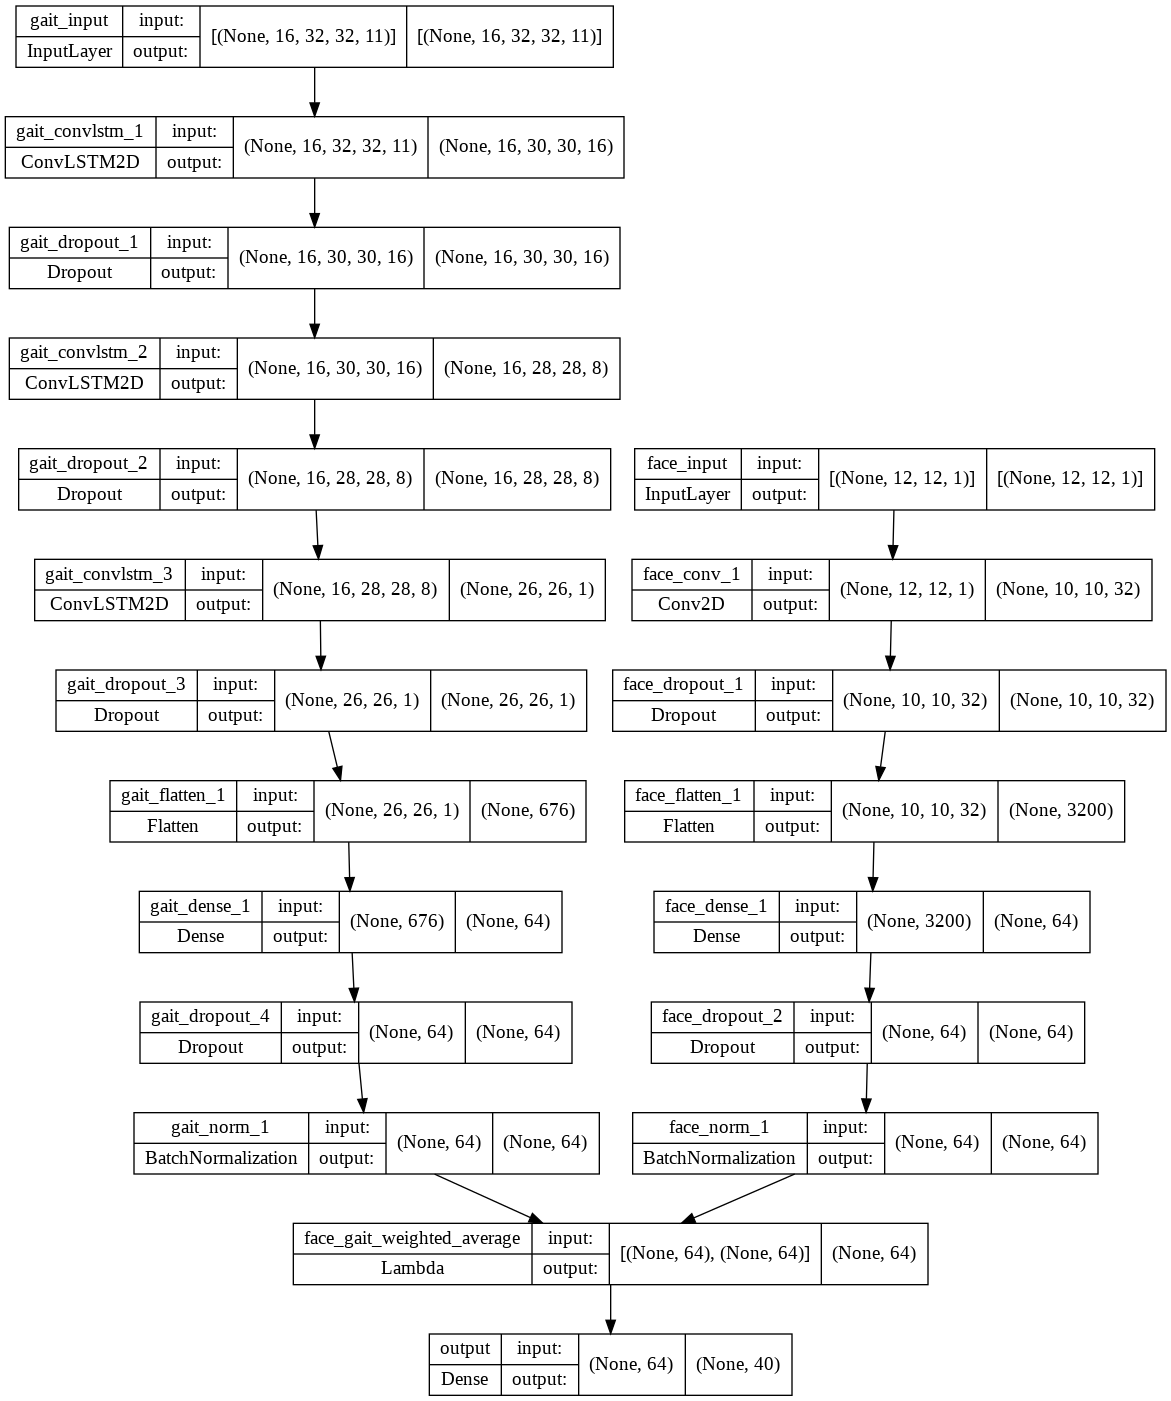

In [8]:
plot = plot_model(model, show_shapes = True, to_file = 'model.png', show_layer_names = True)
display(plot)

In [9]:
EPOCHS = 10
BATCH_SIZE = 16

history = model.fit([x_face, x_gait], y, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    validation_data = ([x_face_val, x_gait_val], y_val), validation_batch_size = BATCH_SIZE)

Epoch 1/10
123/123 [==============================] - 52s 299ms/step - loss: 3.3663 - accuracy: 0.1357 - val_loss: 3.1711 - val_accuracy: 0.3778
Epoch 2/10
123/123 [==============================] - 35s 286ms/step - loss: 2.6470 - accuracy: 0.4571 - val_loss: 2.5767 - val_accuracy: 0.5222
Epoch 3/10
123/123 [==============================] - 35s 285ms/step - loss: 1.6253 - accuracy: 0.7974 - val_loss: 1.3124 - val_accuracy: 0.8806
Epoch 4/10
123/123 [==============================] - 35s 282ms/step - loss: 0.8291 - accuracy: 0.9607 - val_loss: 0.7621 - val_accuracy: 0.9667
Epoch 5/10
123/123 [==============================] - 35s 284ms/step - loss: 0.4606 - accuracy: 0.9852 - val_loss: 0.5341 - val_accuracy: 0.9611
Epoch 6/10
123/123 [==============================] - 35s 282ms/step - loss: 0.2569 - accuracy: 0.9929 - val_loss: 0.3574 - val_accuracy: 0.9667
Epoch 7/10
123/123 [==============================] - 35s 284ms/step - loss: 0.1680 - accuracy: 0.9964 - val_loss: 0.2969 - val_ac

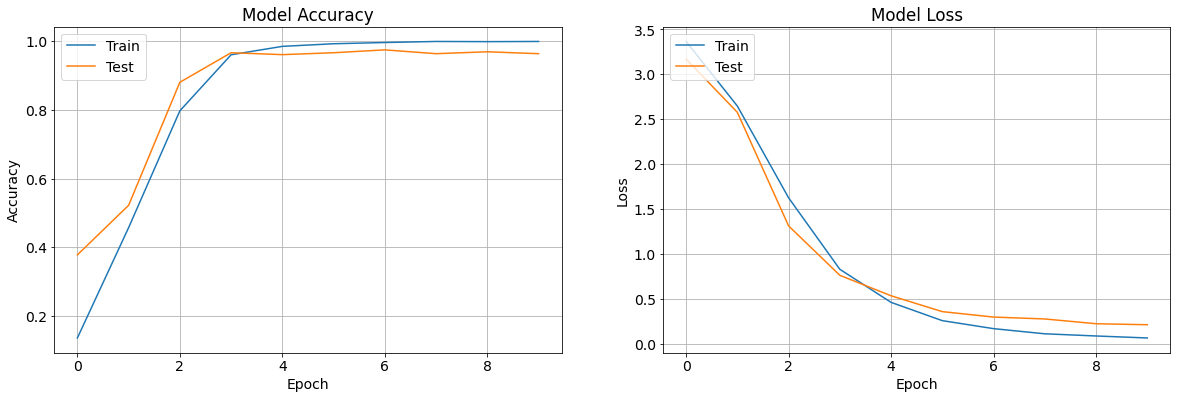

In [10]:
plt.rcParams['figure.figsize'] = (20, 6)
plt.rcParams['font.size'] = 14

fig, ax = plt.subplots(1, 2)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Test'], loc='upper left')
ax[0].grid()

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Test'], loc='upper left')
ax[1].grid()

plt.show()